In [1]:
from Games.CoopEnv import CoopEnv
import numpy as np
import tensorflow as tf
import tensorflow_probability as tfp
import matplotlib.pyplot as plt

In [2]:
n = 5
tasks = 3
cnf = 0.1
env = CoopEnv(n=n, task_num=tasks, cnf=cnf)
action_size = env.num_of_tasks

In [3]:
class Agent():

    class ActorNetwork(tf.keras.Model):
    
        def __init__(self, action_size):
            
            super().__init__()
            # Shared layers for policy and value function networks
            self.layer1 = tf.keras.layers.Dense(256, activation = 'relu')
            self.layer2 = tf.keras.layers.Dense(256, activation = 'relu')
            self.pout = tf.keras.layers.Dense(action_size, activation = 'softmax') # state to action probabilities 
            
        def call(self, state):
            
            x = tf.convert_to_tensor(state)
            x = self.layer1(x)
            x = self.layer2(x)
            probs = self.pout(x)
            
            return probs

    class CriticNetwork(tf.keras.Model):
    
        def __init__(self):
            
            super().__init__()
            # Shared layers for policy and value function networks
            self.layer1 = tf.keras.layers.Dense(256, activation = 'relu')
            self.layer2 = tf.keras.layers.Dense(256, activation = 'relu')
            self.vout = tf.keras.layers.Dense(1, activation = None) # ... from state to value scalar
            
        def call(self, state):
            
            x = tf.convert_to_tensor(state)
            x = self.layer1(x)
            x = self.layer2(x)
            value = self.vout(x)
            
            return value
    
    def __init__(self, action_size):
        self.aModel = self.ActorNetwork(action_size)
        self.vModel = self.CriticNetwork()
        self.gamma = 0.99
        self.alr = 1e-4
        self.clr = 1e-4
        self.aopt = tf.keras.optimizers.Adam(learning_rate=self.alr)
        self.copt = tf.keras.optimizers.Adam(learning_rate=self.clr)
        
    def choose_action(self, state):
        a_probs = self.aModel(np.array([state]))
        dist = tfp.distributions.Categorical(probs = a_probs, dtype=tf.float32)
        action = dist.sample()
        return int(action.numpy()[0])
    
    def calculate_loss(self, a_probs, action, delta):
        dist = tfp.distributions.Categorical(probs = a_probs, dtype=tf.float32)
        log_prob = dist.log_prob(action) # get log(pi(a\s))
        return -log_prob*delta
    
    def train(self, state, action, reward, next_state, terminated): # train from an episode of experience
        
        state = np.array([state])
        next_state = np.array([next_state])
        
        with tf.GradientTape() as tape1, tf.GradientTape() as tape2:
            
            a =  self.aModel(state,training=True) # action probabilities and value of state S_t
            v = self.vModel(state, training=True) # action probabilities and value of state S_t+1
            v_p = self.vModel(next_state, training=True)
            td = reward + self.gamma*v_p - v # calculate TD error
            
            a_update = self.calculate_loss(a, action, td)
            c_update = td**2
        
        grads1 = tape1.gradient(a_update, self.aModel.trainable_variables)
        grads2 = tape2.gradient(c_update, self.vModel.trainable_variables)
        self.aopt.apply_gradients(zip(grads1, self.aModel.trainable_variables))
        self.copt.apply_gradients(zip(grads2, self.vModel.trainable_variables))
        
        return a_update, c_update


In [4]:
num_of_sims = 1
step_limit = 5000
steps_to_complete = np.zeros((num_of_sims, step_limit+1))

In [5]:
def main():
    
    for s in range(num_of_sims):
        
        print("----------------------------------")
        print(f"Starting training simulation {s}:")
        print("----------------------------------")
        
        # reinitialise agent list each sim
        agentlist = {}
        for agent in range(env.n):
            agentlist[agent] = Agent(action_size) # instantiate an Agent() class for each player
         
        t = 0
        observations = env.reset(n=n, task_num=tasks, cnf=cnf)
        
        while t < step_limit:
            print(t, end='\r')

            actions = [agentlist[agent].choose_action(observations[agent]) for agent in range(env.n)]

            next_observations, rewards, termination, info = env.step(actions)
            
            for i in agentlist:
                agent = agentlist[i]
                agent.train(observations[i], actions[i], rewards[i], next_observations[i], termination)

            observations = next_observations
            steps_to_complete[s, t+1] = sum(rewards) + steps_to_complete[s, t]
            t +=1

            


In [6]:
if __name__ == "__main__":
    
    #cProfile.run('main()')
    main()


----------------------------------
Starting training simulation 0:
----------------------------------


[0.00000000e+00 4.31570791e+00 8.72036091e+00 ... 5.13457514e+04
 5.13573655e+04 5.13689795e+04]


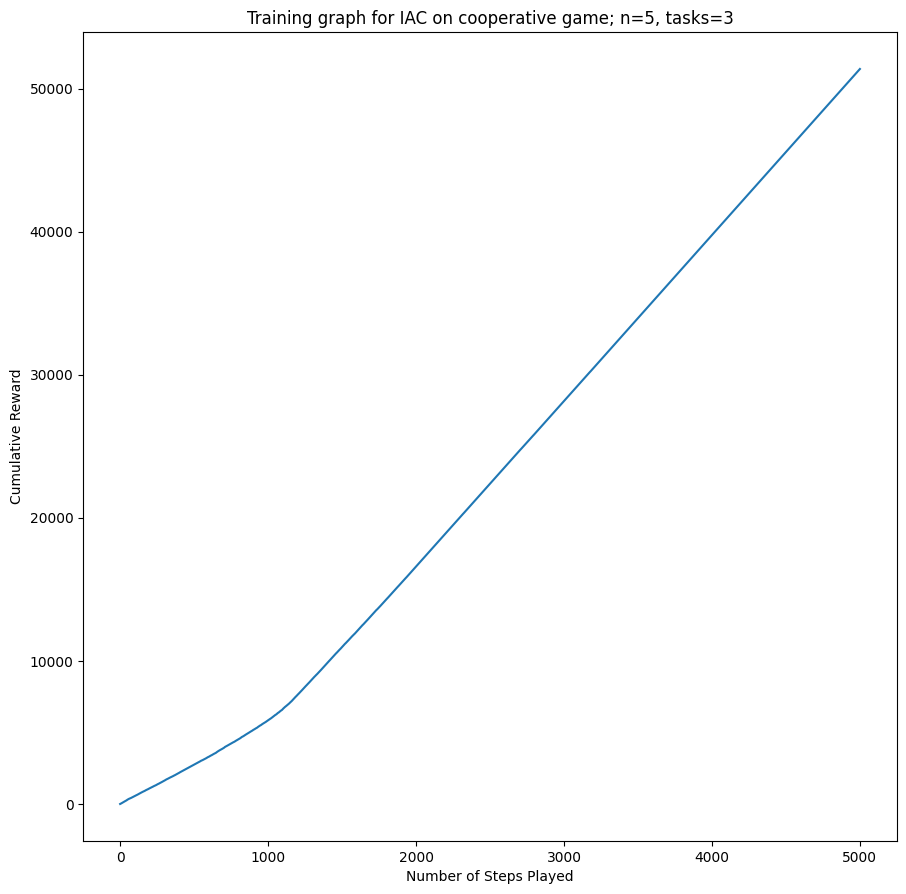

In [7]:
b = np.mean(steps_to_complete, axis=0)
print(sum(steps_to_complete))
plt.xlabel('Number of Steps Played')
plt.ylabel('Cumulative Reward')
plt.title(f'Training graph for IAC on cooperative game; n={n}, tasks={tasks}')
fig = plt.gcf()
fig.set_size_inches(10.5, 10.5)
plt.plot(b)